In [313]:
%matplotlib inline
#Python
import math, time, random, datetime

#Data Manipulations
import numpy as np
import pandas as pd
import seaborn as sns

#Visuals
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

# Machine learning
import sklearn
import catboost
import xgboost as xgb

In [314]:
#Import train & test data
df = pd.read_csv('NVDA-2.csv')

In [315]:
df.head()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
246,2022-10-17,115.180000,119.480003,115.169998,118.879997,118.879997,58077400
247,2022-10-18,123.440002,124.919998,116.180000,119.669998,119.669998,65936200
248,2022-10-19,118.790001,123.500000,118.339996,120.510002,120.510002,52313100
249,2022-10-20,121.129997,127.690002,121.050003,121.940002,121.940002,65239800
250,2022-10-21,120.980003,124.980003,118.870003,124.660004,124.660004,60893800


In [316]:
#Adjusting data
df['Date']= pd.to_datetime(df['Date']).dt.date
df = df.rename(columns={'Adj Close': 'AdjClose'})
df.dtypes

Date         object
Open        float64
High        float64
Low         float64
Close       float64
AdjClose    float64
Volume        int64
dtype: object

In [317]:
df.isnull().sum() #no NA values

Date        0
Open        0
High        0
Low         0
Close       0
AdjClose    0
Volume      0
dtype: int64

In [318]:
# df = df.set_index('Date')
# df.index = pd.to_datetime(df.index)

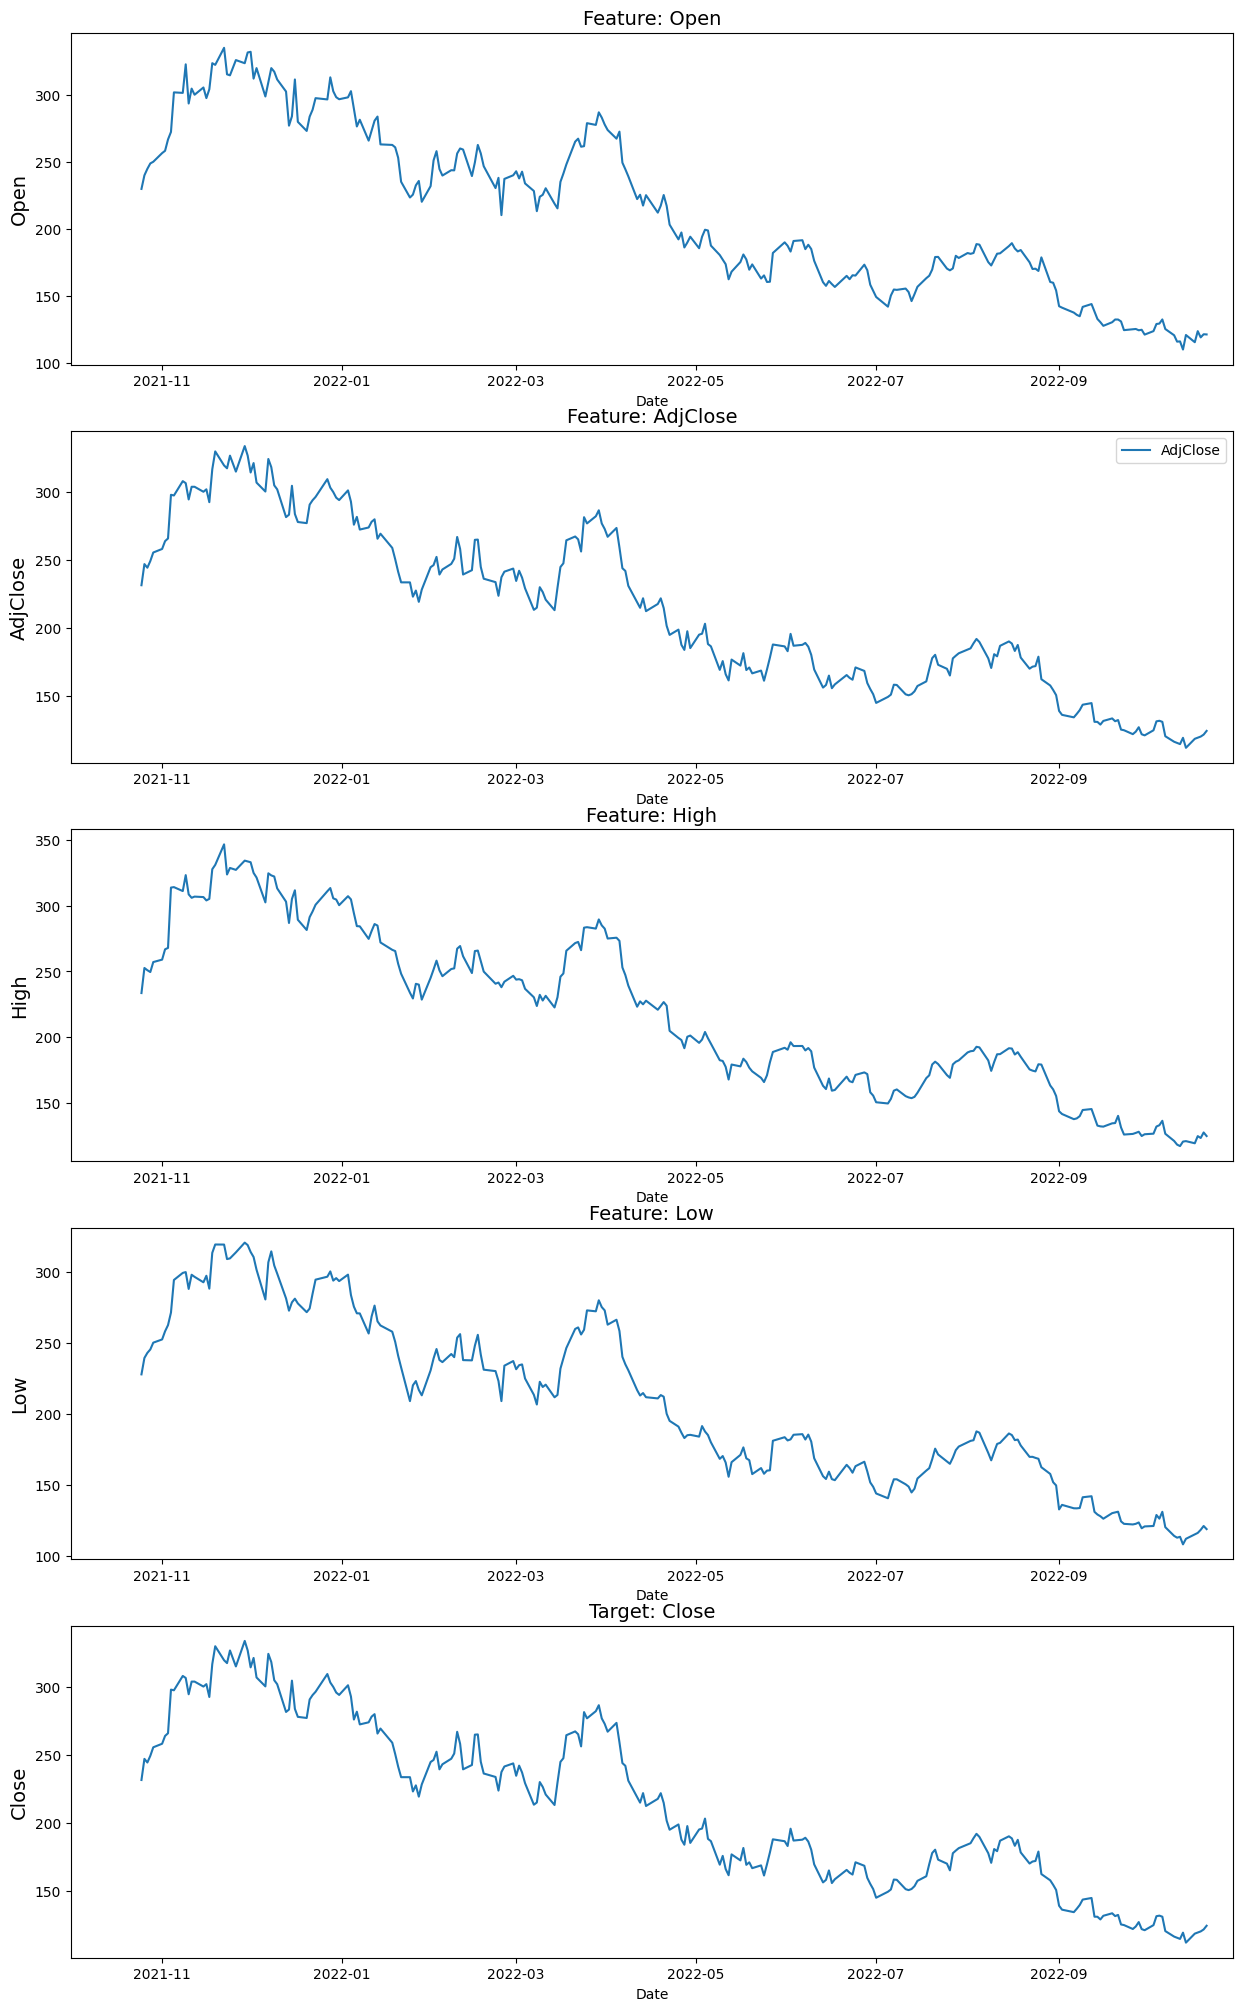

In [319]:
#Analysis of Data 
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

sns.lineplot(x=df.Date, y=df.Open.fillna(np.inf), ax=ax[0])
ax[0].set_title('Feature: Open', fontsize=14)
ax[0].set_ylabel(ylabel='Open', fontsize=14)


sns.lineplot(x=df.Date, y=df.AdjClose.fillna(np.inf), ax=ax[1], label='AdjClose')
ax[1].set_title('Feature: AdjClose', fontsize=14)
ax[1].set_ylabel(ylabel='AdjClose', fontsize=14)


sns.lineplot(x=df.Date, y=df.High.fillna(np.inf), ax=ax[2])
ax[2].set_title('Feature: High', fontsize=14)
ax[2].set_ylabel(ylabel='High', fontsize=14)


sns.lineplot(x=df.Date, y=df.Low.fillna(np.inf), ax=ax[3])
ax[3].set_title('Feature: Low', fontsize=14)
ax[3].set_ylabel(ylabel='Low', fontsize=14)


sns.lineplot(x=df.Date, y=df.Close.fillna(np.inf), ax=ax[4])
ax[4].set_title('Target: Close', fontsize=14)
ax[4].set_ylabel(ylabel='Close', fontsize=14)

from datetime import date
for i in range(5):
    ax[i].set_xlim([date(2021, 10, 1), date(2022, 10, 30)])

plt.show()

#Trend: Decreasing 
#Seasonality: Nil (across this dataset at least)
#Cyclic: Nil (across this dataset at least)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


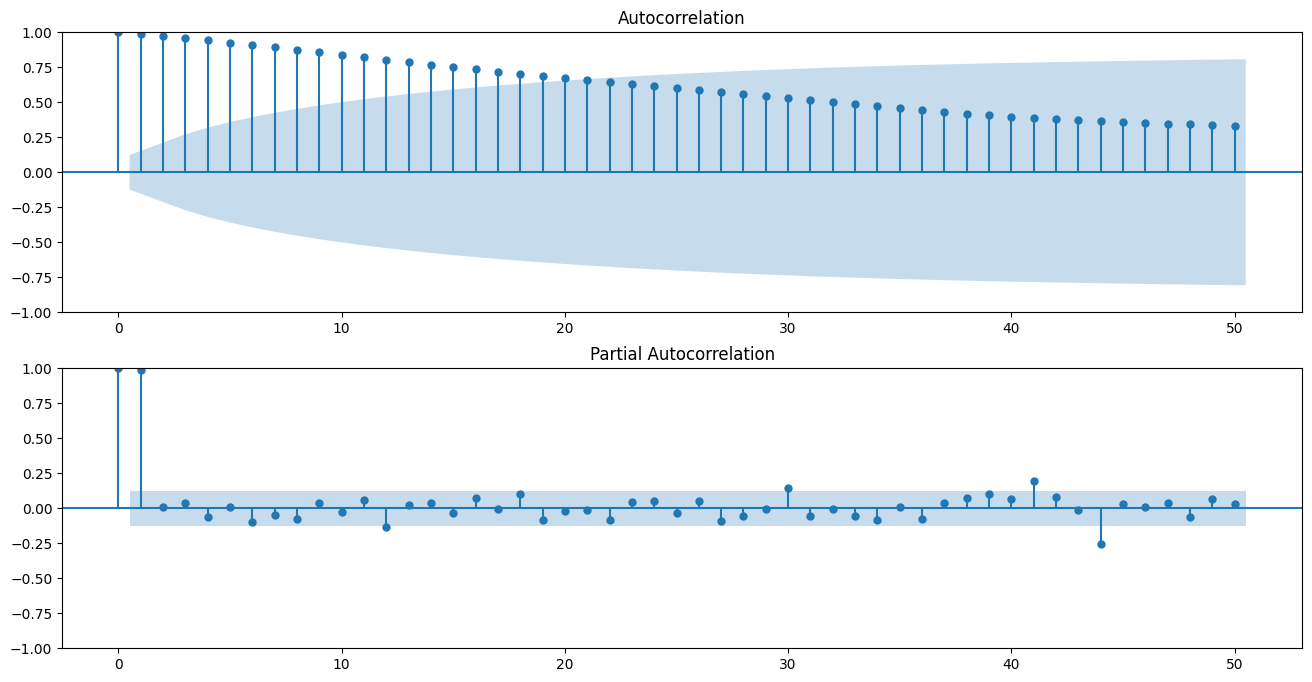

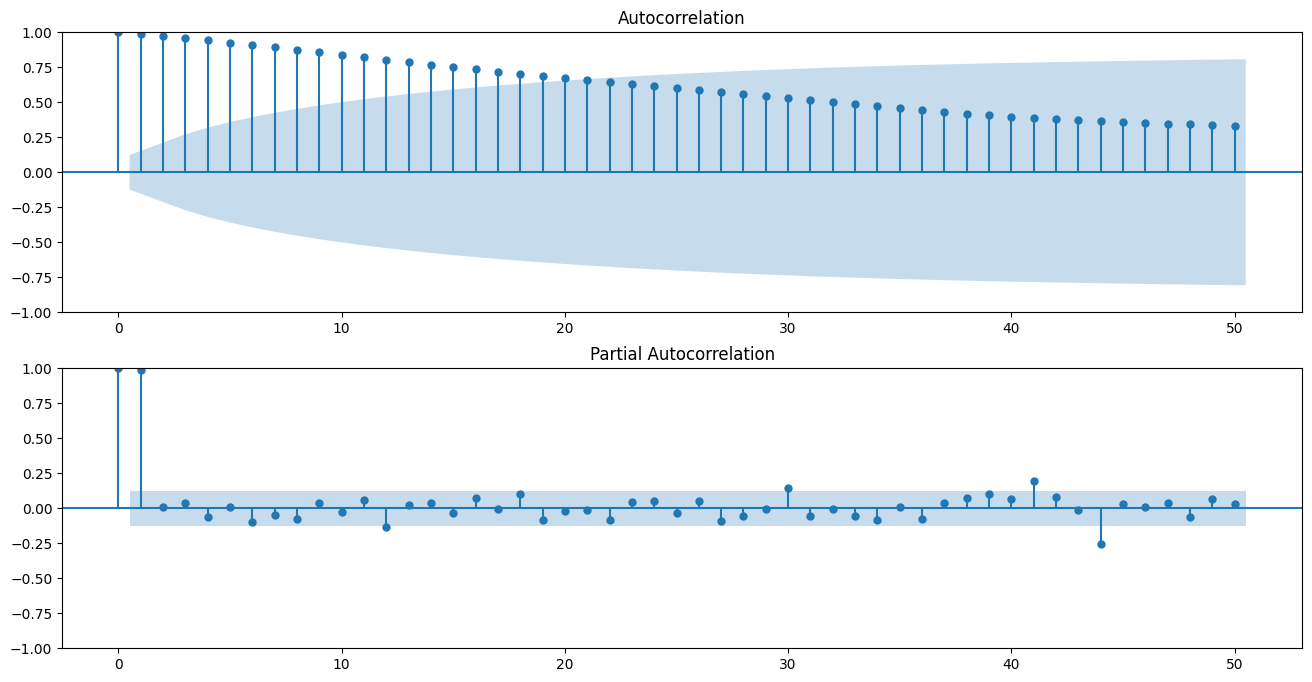

In [320]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df.Close,lags=50, ax=ax[0])
plot_pacf(df.Close,lags=50, ax=ax[1])

#No presence of sinusodial shape in ACF

In [321]:
#Indexing of time and splitting data into train and test

df['time_idx'] = (df.Date != df.Date.shift(1)).cumsum()

target = 'Close'
features = [feature for feature in df.columns if feature != target]

N_SPLITS = 30

splittingtime= datetime.date(2022, 6, 1)
X = df[df.Date <= splittingtime][features]
y = df[df.Date <= splittingtime][target]

X_test = df[df.Date > splittingtime][features]
y_test = df[df.Date > splittingtime][target]


In [322]:
def plot_approach_evaluation(y_pred, score_mae, score_rsme, approach_name,y_valid,y_valid_pred):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
    ax.set_title(f'{approach_name} \n MAE: {mean_absolute_error(y_test, y_pred):.2f}, RSME: {math.sqrt(mean_squared_error(y_valid, y_valid_pred)):.2f}', fontsize=12)

    sns.lineplot(x=X.Date, y=y, ax=ax, color='dodgerblue', label='Training', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_test, ax=ax, color='gold', label='Ground Truth', linewidth=2)
    sns.lineplot(x=X_test.Date,  y=y_pred, ax=ax, color='darkorange', label='Predicted', linewidth=2)
    ax.set_xlabel(xlabel='Date', fontsize=14)
    ax.set_ylabel(ylabel='Closing', fontsize=14)
    plt.show()


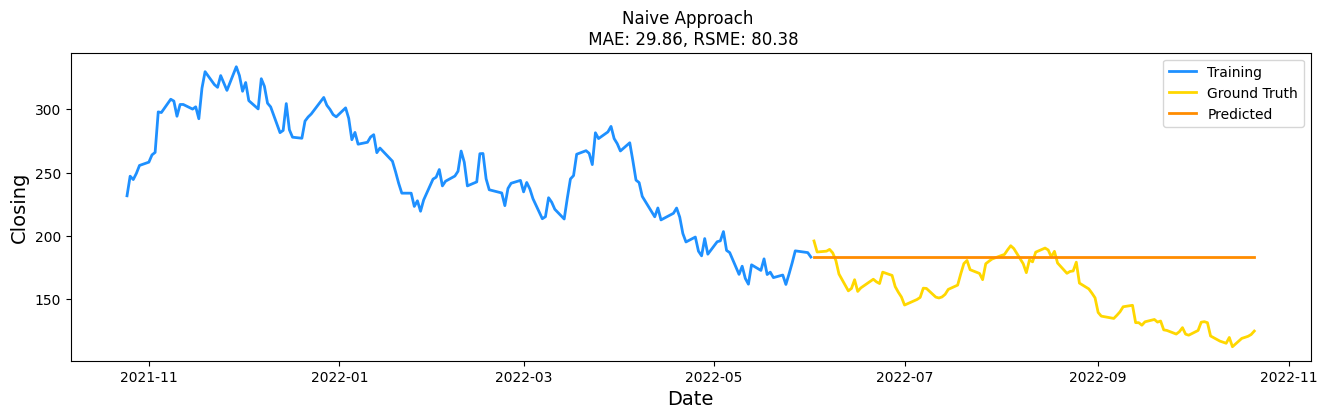

In [323]:
#Naive Approach
score_mae = []
score_rsme = []
    # Get indices for this fold
    # Prepare training and validation data for this fold
y_train, y_valid = y, y_test
y_valid_pred = pd.Series(np.ones(len(y_valid)))
y_valid_pred = y_valid_pred * y_train.iloc[0]
score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

score_mae
score_rsme
y_pred = pd.Series(np.ones(len(X_test))) * y.iloc[-1]
y_pred.index += 152

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Naive Approach',y_valid,y_valid_pred)

/var/folders/cb/3rl907d510d6n8jh8vdyhhcc0000gn/T/ipykernel_12483/3347742534.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred.iloc[i] = y.append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(14).mean().iloc[-1]
/var/folders/cb/3rl907d510d6n8jh8vdyhhcc0000gn/T/ipykernel_12483/3347742534.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred.iloc[i] = y.append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(14).mean().iloc[-1]
/var/folders/cb/3rl907d510d6n8jh8vdyhhcc0000gn/T/ipykernel_12483/3347742534.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred.iloc[i] = y.append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(14).mean().iloc[-1]
/var/folders/cb/3rl907d510d6n8jh8vdyhhcc0000gn/T/ipyker

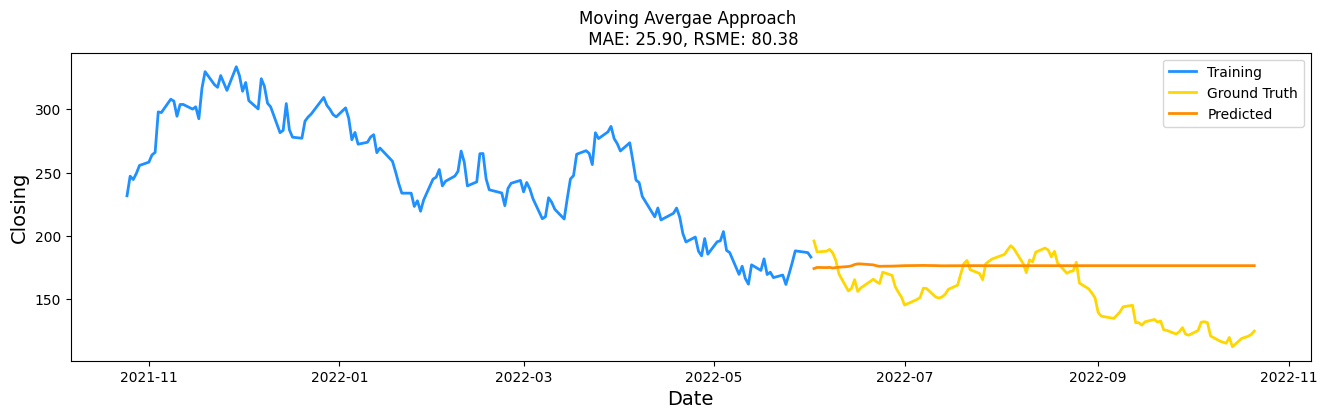

In [324]:
#Moving Avergae Approach

score_mae = []
score_rsme = []
y_train, y_valid = y, y_test
y_valid_pred = pd.Series(np.ones(len(y_valid)))
y_valid_pred = y_valid_pred * y_train.iloc[0]
score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

score_mae
score_rsme
y_pred = pd.Series(np.ones(len(X_test))) * y.iloc[-1]
y_pred.index += 152
for i in range(len(y_pred)):
    y_pred.iloc[i] = y.append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(14).mean().iloc[-1]
    

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Moving Avergae Approach',y_valid,y_valid_pred)


In [379]:
y_pred_ans = pd.Series(np.ones(len(df) + 14)) * df[target].iloc[-1]
y_pred_ans.index += 14
for i in range(len(y_pred_ans)):
    y_pred_ans.iloc[i] = df[target].append(y_pred_ans.iloc[:(i)]).reset_index(drop=True).rolling(14).mean().iloc[-1]
y_pred_ans = y_pred_ans[-14:]
# print(y_pred_ans)

y_pred_ans = pd.DataFrame(np.array(y_pred_ans),
                   columns=['Close'])

y_pred_ans = y_pred_ans.reset_index()
y_pred_ans = y_pred_ans.set_index('index')
print(y_pred_ans)
y_pred_ans.to_csv('YamJinHaoMaxim_Impl_1.csv')

            Close
index            
0      120.051714
1      120.051714
2      120.051714
3      120.051714
4      120.051714
5      120.051714
6      120.051714
7      120.051714
8      120.051714
9      120.051714
10     120.051714
11     120.051714
12     120.051714
13     120.051714


/var/folders/cb/3rl907d510d6n8jh8vdyhhcc0000gn/T/ipykernel_12483/1343709232.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred_ans.iloc[i] = df[target].append(y_pred_ans.iloc[:(i)]).reset_index(drop=True).rolling(14).mean().iloc[-1]
/var/folders/cb/3rl907d510d6n8jh8vdyhhcc0000gn/T/ipykernel_12483/1343709232.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred_ans.iloc[i] = df[target].append(y_pred_ans.iloc[:(i)]).reset_index(drop=True).rolling(14).mean().iloc[-1]
/var/folders/cb/3rl907d510d6n8jh8vdyhhcc0000gn/T/ipykernel_12483/1343709232.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred_ans.iloc[i] = df[target].append(y_pred_ans.iloc[:(i)]).reset_index(drop=True).rolling(14).mean().iloc[-1]
/var/fo

/var/folders/cb/3rl907d510d6n8jh8vdyhhcc0000gn/T/ipykernel_12483/40737630.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_var= np.array(df.drop(["Prediction"],1))
/var/folders/cb/3rl907d510d6n8jh8vdyhhcc0000gn/T/ipykernel_12483/40737630.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  forecast = np.array(df.drop(["Prediction"],1))[-15:]


[223.3444498 223.3444498 223.3444498 223.3444498 223.3444498 223.3444498
 223.3444498 223.3444498 223.3444498 223.3444498 223.3444498 223.3444498
 223.3444498 223.3444498 223.3444498]


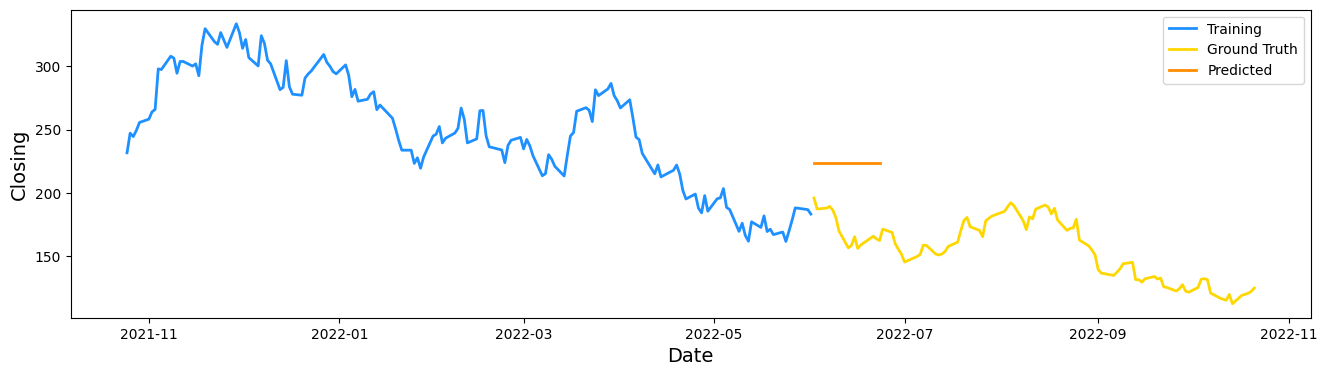

In [326]:
#SVM Model

df = pd.read_csv('NVDA-2.csv')
df = df.rename(columns={'Adj Close': 'AdjClose'})

df.index = pd.to_datetime(df['Date'])
df = df.drop(['Date'], axis='columns')

df["Prediction"] = df[["Close"]].shift(-15)
train_var= np.array(df.drop(["Prediction"],1))
train_var = train_var[:-15]
# print(train_var)

train_pred = np.array(df["Prediction"])
# # Remove Last 15 rows
train_pred = train_pred[:-15]
# print(train_pred)
split = int(0.8*len(df))
XTRAIN = train_var[:split]
YTRAIN = train_pred[:split]
XTEST = train_var[split:]
YTEST = train_pred[split:]
svr = SVR(kernel="rbf", C=1e3, gamma=0.1)
# # # # # Train the model 
svr.fit(XTRAIN, YTRAIN)

forecast = np.array(df.drop(["Prediction"],1))[-15:]
svm_prediction = svr.predict(forecast)
print(svm_prediction)

# fc_series = pd.Series(svm_prediction, index = y.index)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
sns.lineplot(x=X.Date, y=y, ax=ax, color='dodgerblue', label='Training', linewidth=2)
sns.lineplot(x=X_test.Date, y=y_test, ax=ax, color='gold', label='Ground Truth', linewidth=2)
sns.lineplot(x=X_test.Date[:15],  y=svm_prediction, ax=ax, color='darkorange', label='Predicted', linewidth=2)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Closing', fontsize=14)
plt.show()


Part 2: We will focus on using ARIMA model

In [327]:
import pmdarima
model_auto = pmdarima.auto_arima(y, start_p = 0, start_q = 0, 
                        test ="adf", 
                        max_p = 7, max_q = 7,
                        m=1,
                        d=None,
                        seasonal = False,
                        start_P=0,
                        D=0,
                        trace = True,
                        error_action = 'ignore',
                        supress_warnings = True,
                        stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1137.335, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1138.415, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1138.299, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1135.482, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1140.166, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.204 seconds


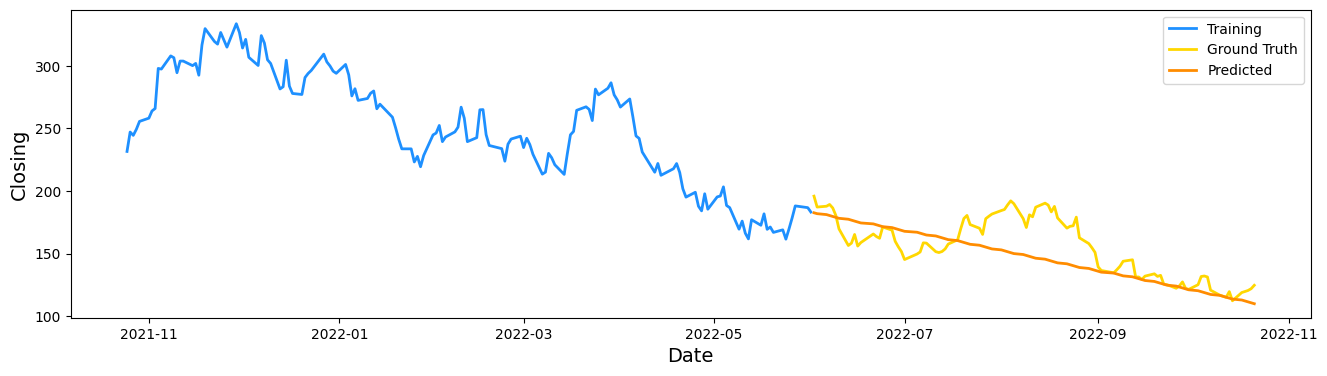

In [328]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(y, order =(1,2,2))
model = arima_model.fit()
# print(model.summary())
fc = model.forecast(99,alpha=0.05)

fc_series = pd.Series(fc, index = y.index)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
sns.lineplot(x=X.Date, y=y, ax=ax, color='dodgerblue', label='Training', linewidth=2)
sns.lineplot(x=X_test.Date, y=y_test, ax=ax, color='gold', label='Ground Truth', linewidth=2)
sns.lineplot(x=X_test.Date,  y=fc, ax=ax, color='darkorange', label='Predicted', linewidth=2)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Closing', fontsize=14)
plt.show()

In [380]:
fc_pred = model.forecast(99+14,alpha=0.05)
fc_pred = fc_pred[-14:]
# fc_pred = fc_pred.reset_index()
# fc_pred = fc_pred.drop(columns = 'index')
# print(fc_pred)

fc_pred = pd.DataFrame(np.array(fc_pred),
                   columns=['Close'])

fc_pred = fc_pred.reset_index()
fc_pred = fc_pred.set_index('index')
print(fc_pred)


fc_pred.to_csv('YamJinHaoMaxim_Impl_2.csv')

            Close
index            
0      109.174508
1      108.432277
2      107.690045
3      106.947813
4      106.205581
5      105.463350
6      104.721118
7      103.978886
8      103.236654
9      102.494423
10     101.752191
11     101.009959
12     100.267727
13      99.525496


Other models that were considered but not implemented 

In [330]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X, y,
        eval_set=[(X_test, y_test)],
        verbose=100)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:Date

In [ ]:
#VAR not rly useful here

from statsmodels.tsa.api import VAR
score_mae = []
score_rsme = []
    # Get indices for this fold
    # Prepare training and validation data for this fold
X_train, X_valid = X, X_test
y_train, y_valid = y, y_test
y_valid_pred = pd.Series(np.ones(len(y_valid)))
y_valid_pred = y_valid_pred * y_train.iloc[0]
score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

score_mae
score_rsme
print(X[features])
print(pd.concat([y, X[features]]))

model = VAR(df[df.Date <= splittingtime])

# model = VAR(pd.concat([y, X[features]], axis=1))
# model_fit = model.fit()

# # Prediction with Vector Auto Regression (VAR)
# y_pred = model_fit.forecast(model_fit.y, steps=len(X_valid))
# y_pred = pd.Series(y_pred[:, 0])
# y_pred.index += 80
# plot_approach_evaluation(y_pred, score_mae, score_rsme, 'VAR',y_valid,y_valid_pred)